# Orders EDA

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

%cd /home/user_3/medistream-recsys/Script
from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

/home/user_3/medistream-recsys/Script


# 1.Dataload

In [289]:
# products name 확인 용
products_df = pd.read_json("/fastcampus-data/products/products.json")
products_df = key_to_element(['_id'],products_df)

100%|██████████| 5141/5141 [00:00<00:00, 655527.36it/s]


In [290]:
df = pd.read_json('/fastcampus-data/select_column_version_4.json')

In [291]:
df['date_paid'] = pd.to_datetime(df['date_paid'])

In [292]:
# 전체 기간
df['date_paid'].min(), df['date_paid'].max()

(Timestamp('2019-08-26 02:41:49.950000+0000', tz='UTC'),
 Timestamp('2022-09-13 08:59:21.151000+0000', tz='UTC'))

In [293]:
df['date_paid'].max() - df['date_paid'].min()

Timedelta('1114 days 06:17:31.201000')

In [294]:
# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# 취소 안된 것만 가져오기
complete_df = df_only_paid[(df_only_paid['paid'] == True) & (df_only_paid['cancelled']==False)]
# 도서 카테고리만 가져오기
only_book = complete_df[complete_df['name'] == '도서']

# 유저가 중복으로 아이템 구매 삭제
df_duplicated_book = only_book.drop_duplicates(subset=['customer_id','product_ids'])
df_book = df_duplicated_book.sort_values(by='date_paid').reset_index(drop=True)

In [295]:
# none 값 확인하기
df_book.isna().sum()

_id                 0
date_created        0
regular_price       0
sale_price          0
three_months        0
date_paid           0
customer_id         0
paid                0
name_x              0
category_id_y       0
product_ids         0
quantity            0
price               0
price_total         0
age_group        3007
한의사 여부             79
사업자 여부             79
cancelled           0
name                0
slug                0
dtype: int64

# 2.전체 데이터 EDA

In [296]:
print('중복 제거 전:',len(only_book), '중복 제거 후:',len(df_book))

중복 제거 전: 38395 중복 제거 후: 37866


In [297]:
print('전체 데이터 수:',len(df_book))

전체 데이터 수: 37866


In [298]:
print('아이템 수:',len(df_book.product_ids.unique()),'유저 수:',len(df_book.customer_id.unique()))

아이템 수: 342 유저 수: 7410


## 전체 아이템 중복 확인

In [299]:
# product_ids, name_x 일치하지 않음, 전처리 필요
len(df_book.product_ids.unique()), len(df_book.name_x.unique())

(342, 370)

In [300]:
# 중복 제거 후 수 비교 확인
len(df_book.drop_duplicates(subset=['product_ids','name_x']).name_x.unique())

370

In [301]:
product_name_preprocess_df = df_book.copy()

In [302]:
# 각 마지막 product_ids, name으로 채우기
product_ids_to_name = {}
for idx, row in product_name_preprocess_df.iterrows():
    product_ids_to_name[row.product_ids] = row.name_x
product_name_preprocess_df['name_x'] = product_name_preprocess_df['product_ids'].apply(lambda x: product_ids_to_name[x])

name_to_product_ids = {}
for idx, row in product_name_preprocess_df.iterrows():
    name_to_product_ids[row.name_x] = row.product_ids
product_name_preprocess_df['product_ids'] = product_name_preprocess_df['name_x'].apply(lambda x: name_to_product_ids[x])

In [303]:
# product_ids, name_x 일치 확인
len(product_name_preprocess_df.product_ids.unique()), len(product_name_preprocess_df.name_x.unique())

(340, 340)

In [304]:
# name, product 전처리에 따라서 다시 중복 제거
df_reduplicated_book = product_name_preprocess_df.drop_duplicates(subset=['customer_id','product_ids'])
preprocessed_book_df = df_reduplicated_book.sort_values(by='date_paid').reset_index(drop=True)

In [305]:
print('전체 유저 수:',len(set(preprocessed_book_df.customer_id)))

전체 유저 수: 7410


In [306]:
# 아이템 수
print('전체 아이템 수:', len(set(preprocessed_book_df.product_ids)))

전체 아이템 수: 340


In [307]:
# 전체 구매 백분율

len(preprocessed_book_df)/(len(set(preprocessed_book_df.customer_id))*len(set(preprocessed_book_df.product_ids)))

0.015028578232912598

- 넷플릭스 유저: 480,189, 아이템:17,770, 피드백 수:100,480,507 백분율:1.178
- 매우 낮은 편에 속한다고 볼 수 있음..

In [308]:
print('유저 최대 구매 횟수:',preprocessed_book_df.customer_id.value_counts().max())
print('유저 중간 구매 횟수:',preprocessed_book_df.customer_id.value_counts().median())
print('유저 최소 구매 횟수:',preprocessed_book_df.customer_id.value_counts().min())

유저 최대 구매 횟수: 130
유저 중간 구매 횟수: 3.0
유저 최소 구매 횟수: 1


- 최대, 중간, 최소 구매한 유저 10명을 샘플링하여서 구매 주기 시각화

# 유저 아이템 구매 시기별 시각화

In [309]:
from datetime import datetime,date
preprocessed_book_df['date_created'] = pd.to_datetime(preprocessed_book_df['date_created']).dt.date
preprocessed_book_df['date_created'].max()

datetime.date(2022, 9, 7)

In [310]:
dat_groupby = preprocessed_book_df.groupby(['date_created'])[['product_ids']].count().reset_index().rename(columns={'product_ids':'cnt'})
dat_sort = dat_groupby.sort_values(by='date_created')

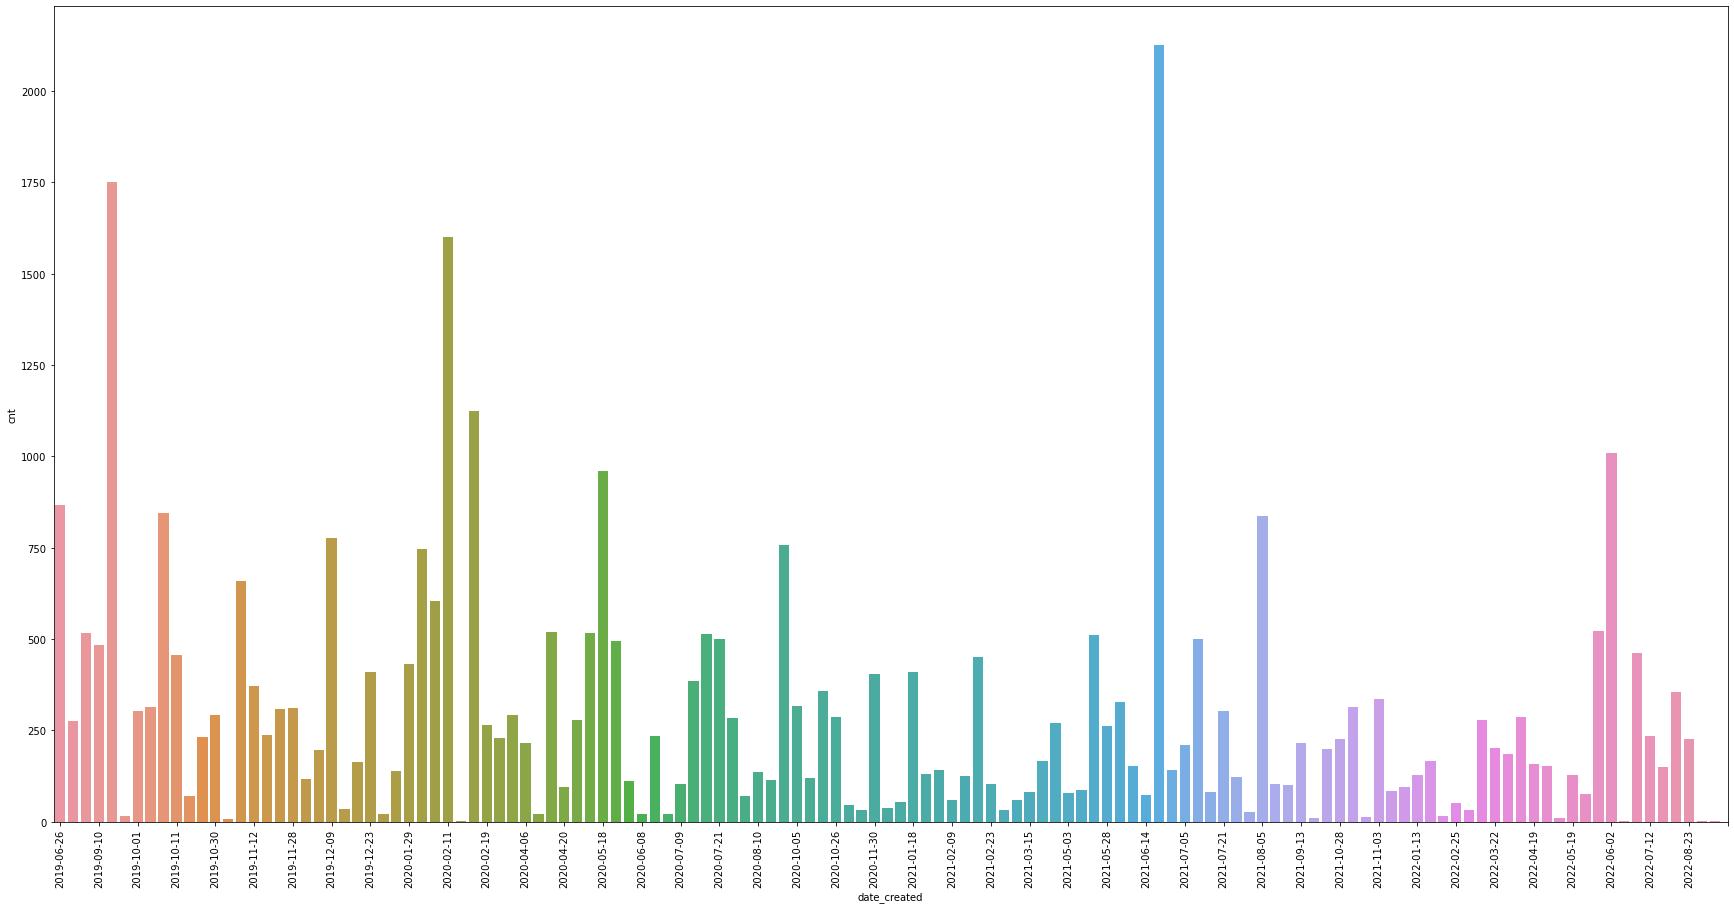

In [311]:
x = dat_sort['date_created']
y = dat_sort['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 3))
plt.xticks(rotation=90)
plt.show()

- 특정 일자가 갑자기 매출이 급등하는 현상을 보임
- 메디스트림 측에 문의 결과 주마다 도서에 대한 프로모션을 진행함

In [312]:
most_popular_list = preprocessed_book_df.groupby(['name_x','product_ids']).count()['customer_id'].reset_index().rename(columns={'customer_id':'cnt'})

In [313]:
dt_sort_cnt = preprocessed_book_df.copy()
dt_sort_cnt_add = pd.merge(dt_sort_cnt, most_popular_list[['product_ids','cnt']], how='left', on='product_ids')

In [314]:
top20_product_ids = most_popular_list.sort_values(by='cnt',ascending=False).head(20).product_ids.values

In [315]:
top20_df = dt_sort_cnt_add[dt_sort_cnt_add['product_ids'].isin(top20_product_ids)].drop_duplicates(subset=['name_x','product_ids'], ignore_index=True)
top20_df.sort_values(by=['date_created','cnt'], ascending=False)[['date_created','sale_price','three_months','name_x','product_ids','cnt']]

,date_created,sale_price,three_months,name_x,product_ids,cnt
19,2022-06-29,57000.0,463.0,플로차트 정형외과 진단,62bbee3a08e04900234e36c8,461
18,2022-06-02,42750.0,596.0,비만문답,629860599d93880024071acc,592
17,2021-08-05,76500.0,109.0,임상 한의사를 위한 기본 한약처방 강의 2판,610b6f9ad26af90681b1e699,838
16,2021-07-09,36100.0,35.0,침의 과학적 접근의 이해,60e7e0b0d26af90681b1b61c,499
15,2021-06-21,18000.0,219.0,윤상훈·권병조의 알짜 근육학,60d018b7d26af90681b18980,2126
14,2021-05-17,18000.0,0.0,통장잔고 2배 늘려주는 병의원 절세비법,60a22e62c1908b001a6466e1,512
13,2021-01-18,64800.0,28.0,근골격계 약침의학,6005151da6432d001a69b21b,409
12,2020-09-21,45000.0,46.0,사상방 사용설명서,5f6860f348060c52caf14690,757
11,2020-04-27,45000.0,4.0,사진으로 공부하는 이비인후과학,5ea643ec1a3ca36b96784a07,516
10,2020-04-13,47700.0,6.0,한방처방정석,5e93e5d6bfe426094478533e,520


- 눈에 띄게 많이 팔리는 도서들 확인
- 최신 도서임에도 많이 팔리는 아이템들이 있음
- 프로모션 기간으로 인해 갑자기 많이 팔리는 현상이라고 판단

In [343]:
before_product_df = preprocessed_book_df.groupby('product_ids')[['product_ids']].count().rename(columns={'product_ids':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)

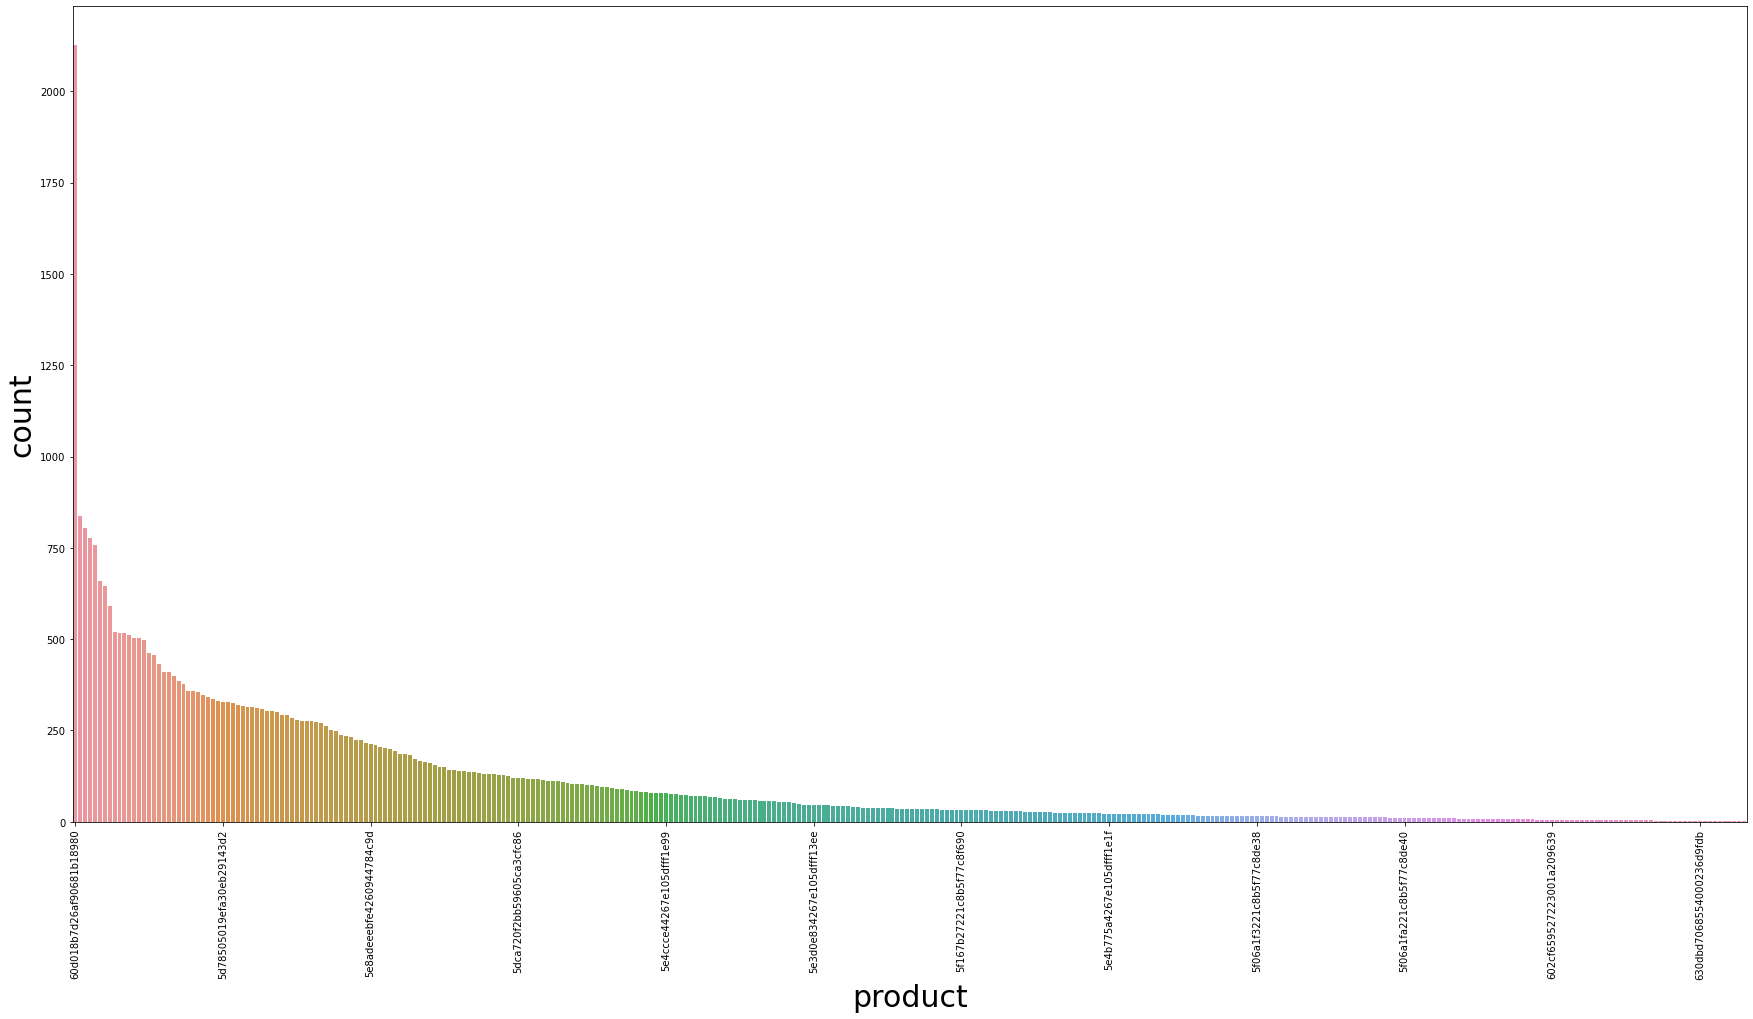

In [355]:
x = before_product_df['product_ids']
y = before_product_df['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
ax.set_xlabel('product',fontsize=30)
ax.set_ylabel('count',fontsize=30)
plt.xticks(rotation=90)
plt.show()

In [345]:
print('제품 누적 판매 횟수:', before_product_df.max())

제품 누적 판매 횟수: product_ids    63182f4d6c2e37002369d6bc
cnt                                2126
dtype: object


In [359]:
print('제품 medina 판매 횟수:', before_product_df.median())

제품 medina 판매 횟수: cnt    35.0
dtype: float64


In [347]:
before_user_group_df = all_promotion_df.groupby('customer_id')[['customer_id']].count().rename(columns={'customer_id':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)

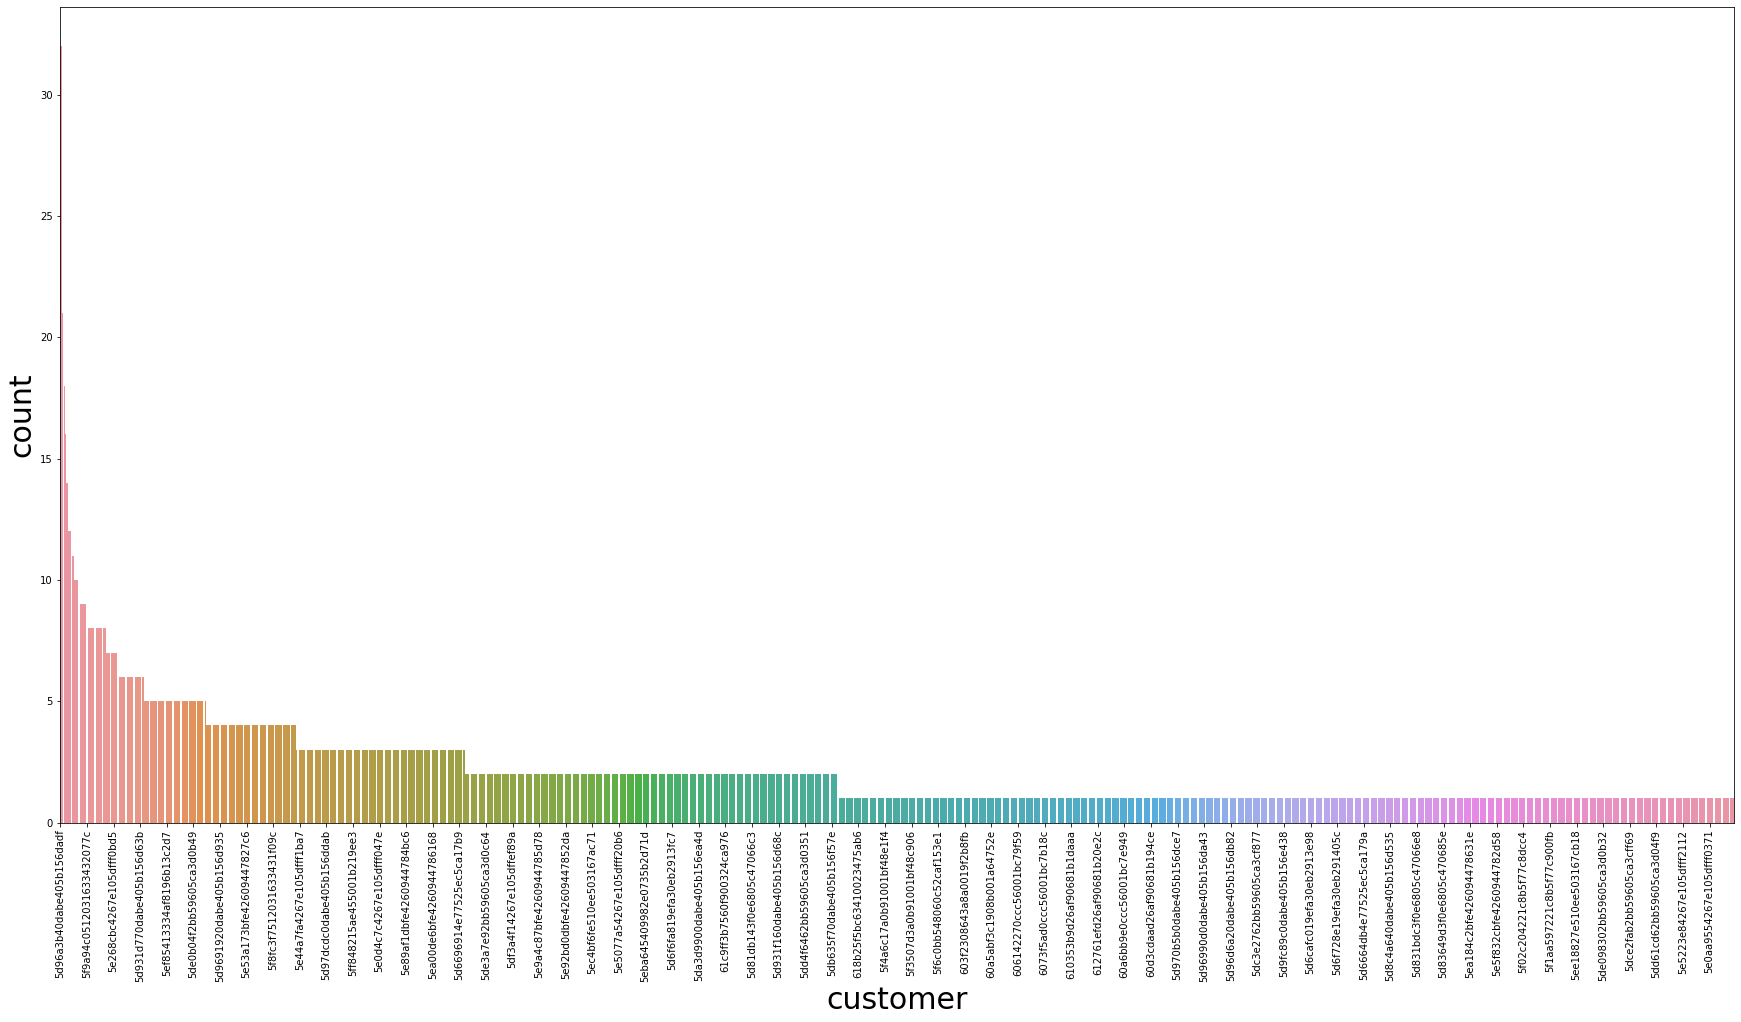

In [354]:
x = before_user_group_df['customer_id']
y = before_user_group_df['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
ax.set_xlabel('customer',fontsize=30)
ax.set_ylabel('count',fontsize=30)
plt.xticks(rotation=90)
plt.show()

In [349]:
print('유저 최대 누적 구매 횟수:',before_user_group_df.max())

유저 최대 누적 구매 횟수: customer_id    62e87979a3d1d80023058b36
cnt                                  32
dtype: object


In [350]:
print('유저 median 누적 구매 횟수:',before_user_group_df.median())

유저 median 누적 구매 횟수: cnt    1.0
dtype: float64


# 2.train test split
- train : 2022-01-01 ~ 2022-08-22 , test: 2022-08-23 ~ 2022-09-13
- EDA 하기 위해서 train 기간을 이렇게 잡음, 이후 실험을 통해 기간을 달라질 수 있음
- 전체 데이터 중 마지막 3주치 데이터를 test 선정
- train 없는 test 아이템을 전처리 진행없이 학습 합니다.

# train test eda

In [244]:
preprocessed_book_df['date_paid'].max()

Timestamp('2022-09-13 08:51:40+0000', tz='UTC')

In [245]:
from datetime import datetime, timedelta
datetime(2022,9,13)-timedelta(days=21)

datetime.datetime(2022, 8, 23, 0, 0)

In [246]:
from datetime import datetime, timedelta
date = '2022-08-23'

train_before = preprocessed_book_df[(preprocessed_book_df['date_paid'] >= '2022-01-01')]
train_before_preprocess = train_before[train_before['date_paid'] < date]
test_before_preprocess = preprocessed_book_df[preprocessed_book_df['date_paid'] >= date]

## train test 아이템 중복 확인

In [247]:
len(train_before_preprocess.product_ids.unique()),len(test_before_preprocess.product_ids.unique())

(280, 131)

In [248]:
len(set(train_before_preprocess.product_ids.unique())-set(test_before_preprocess.product_ids.unique()))

156

In [249]:
# test 아이템에 train 없는 아이템 확인
len(set(test_before_preprocess.product_ids.unique())-set(train_before_preprocess.product_ids.unique()))

7

In [250]:
# test 만 있는 item 제거
only_test_items = set(test_before_preprocess.product_ids.unique())-set(train_before_preprocess.product_ids.unique())
if_prop_test = test_before_preprocess[~test_before_preprocess['product_ids'].isin(only_test_items)]

In [251]:
len(if_prop_test.customer_id.unique()), len(train_before_preprocess.customer_id.unique())

(257, 3464)

In [252]:
# test 변수 명 변경
test = test_before_preprocess.copy()
# train 변수 명 변경
train = train_before_preprocess.copy()

# test 아이템 분포 확인

### 전처리 전후 비교

In [253]:
print('test 전처리 전 아이템:',len(set(test_before_preprocess.product_ids)), 'test 전처리 후 아이템:',len(set(if_prop_test.product_ids)))

test 전처리 전 아이템: 131 test 전처리 후 아이템: 124


- 아이템 7 종류 전처리 됨

In [254]:
print('test 전처리 전:',len(test_before_preprocess), 'test 전처리 후:',len(if_prop_test))

test 전처리 전: 974 test 전처리 후: 389


### user 수 비교 

In [255]:
print('train 유저 수:',len(train.customer_id.unique()))

train 유저 수: 3464


In [256]:
print('test 유저 수:',len(test.customer_id.unique()))

test 유저 수: 744


In [257]:
# 신규 유저는 MP 같은 다른 방법으로 추천 진행해야 함
print('test 만 있는 신규 유저 :',len(set(test['customer_id'].unique())- set(train['customer_id'].unique())))

test 만 있는 신규 유저 : 289


### item 개수 비교

In [258]:
print('train 아이템 수 :',len(set(train.product_ids)), 'test 아이템 수 :',len(set(test.product_ids)))

train 아이템 수 : 280 test 아이템 수 : 131


In [259]:
print('train 만 있는 아이템 수:',  len(set(train.product_ids)-set(test.product_ids)))

train 만 있는 아이템 수: 156


In [260]:
print('test 만 있는 아이템 수:', len(set(test.product_ids) - set(train.product_ids)))

test 만 있는 아이템 수: 7


# test 시각화

In [261]:
test_dat_groupby = test.groupby(['date_paid'])[['product_ids']].count().reset_index().rename(columns={'product_ids':'cnt'})
test_dat_sort = test_dat_groupby.sort_values(by='date_paid')

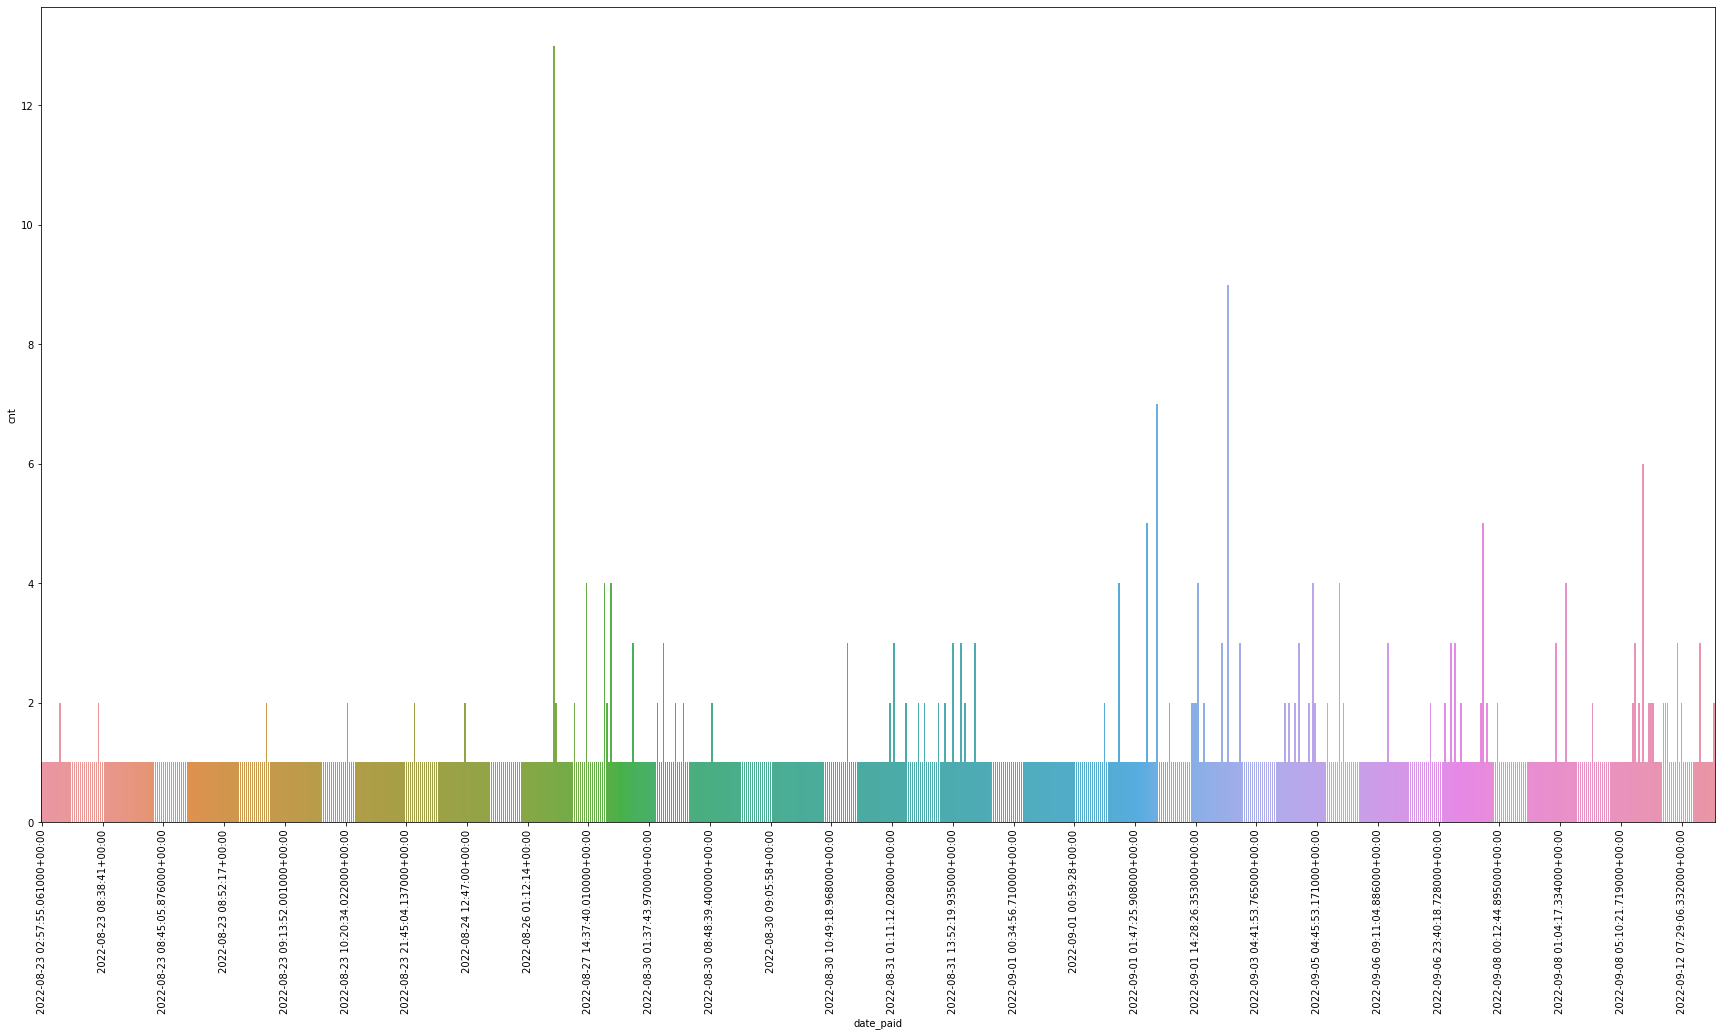

In [262]:
x = test_dat_sort['date_paid']
y = test_dat_sort['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
plt.xticks(rotation=90)
plt.show()

- 특정 기간에 판매 수가 급증 하는 것을 확인 

# promotion train EDA

# 프로모션 책 확인(22년도)

- 전체 데이터를 사용할 것이 아니기 때문에 2022년도 데이터 가지고 활용
- 이유는 시즌성 및 최신성 반영
- 2022년도 프로모션 기간 동안 판매된 프로모션 책을 전처리 진행
- 프로모션 책은 메디스트림에서 제공해준 자료를 바탕으로 확인
- 프로모션 전후 데이터 수 및 test(마지막 3주) 데이터 분포 확인 진행

In [263]:
from datetime import datetime

preprocessed_book_df_date = train.copy()

promotion_book_df = preprocessed_book_df_date[preprocessed_book_df_date['date_paid'] >= '2022-03-01']
promotion_book_df['date_paid_date'] = promotion_book_df['date_paid'].dt.date
promotion_book_df['date_paid_week'] = promotion_book_df['date_paid_date'].apply(lambda x: x.isocalendar()[1])

<ipython-input-263-4a9cdae0ef00>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promotion_book_df['date_paid_date'] = promotion_book_df['date_paid'].dt.date
<ipython-input-263-4a9cdae0ef00>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promotion_book_df['date_paid_week'] = promotion_book_df['date_paid_date'].apply(lambda x: x.isocalendar()[1])


In [264]:
# 1 주차부터 프로모션 책 확인하면 됨
promotion_book_df[['date_paid','date_paid_date','date_paid_week']]

,date_paid,date_paid_date,date_paid_week
29250,2022-03-01 02:41:00+00:00,2022-03-01,9
29251,2022-03-01 04:18:09.283000+00:00,2022-03-01,9
29252,2022-03-01 05:27:07.283000+00:00,2022-03-01,9
29253,2022-03-01 05:27:07.283000+00:00,2022-03-01,9
29254,2022-03-01 05:27:07.283000+00:00,2022-03-01,9
...,...,...,...
36884,2022-08-22 08:50:01.645000+00:00,2022-08-22,34
36885,2022-08-22 09:53:19.813000+00:00,2022-08-22,34
36886,2022-08-22 14:02:43+00:00,2022-08-22,34
36887,2022-08-22 14:02:43+00:00,2022-08-22,34


In [265]:
promotion_dict = {
    2:['트리거포인트 침치료'],
    3:['藥徵, 약의 징표','파킨슨병 한의진료','침의 과학적 접근의 이해','길익동동','Medical acupuncture 침의 과학적 접근과 임상활용',\
      '동의보감 약선','수화론(水火論)'],
    4:['실전한약가이드','음양승강으로 해석하는 사상의학: 생리병리'],
    5:['음양승강으로 해석하는 사상의학: 생리병리'],
    6:['윤상훈·권병조의 알짜 근육학','임상 한의사를 위한 기본 한약처방 강의 2판','트리거포인트 침치료','KCD 한방내과 진찰진단 가이드라인',\
      '실전한약가이드','음양승강으로 해석하는 사상의학: 생리병리','藥徵, 약의 징표','증보운곡본초학','통증치료를 위한 근육 초음파와 주사 테크닉'],
    7:['오국통 온병명방'],
    9:['병태생리 Visual map','NEO 인턴 핸드북','보험한약 브런치 the # 2판 개정판','Kendall 자세와 통증치료에 있어서 근육의 기능과 검사 5판',\
      '사상방 사용설명서','실전한약가이드','일차진료 한의사를 위한 보험한약입문 - 둘째 판','증보운곡본초학'],
    10:['한눈에 보는 스트레칭 해부학'],
    11:['임산부에게 사용할 수 있는 한방처방'],
    12:['임산부에게 사용할 수 있는 한방처방'],
    13:['MRI 자신감 키우기_족부편'],
    14:['장골의 PI 변위는 없다'],
    15:['윤상훈·권병조의 알짜 근육학','임상 한의사를 위한 기본 한약처방 강의 2판','KCD 한방내과 진찰진단 가이드라인','트리거포인트 침치료',\
       '음양승강으로 해석하는 사상의학: 생리병리','침의 과학적 접근의 이해','실전한약가이드','임산부에게 사용할 수 있는 한방처방','한눈에 보는 스트레칭 해부학',\
       'MRI 자신감 키우기_족부편'],
    16:['환자상담의 달인','병의원 경영과 자산 관리 클리닉','우리 병원의 문제? 현장에서 답을 찾다!','근육학','스파이랄 및 키네지오 테이핑',\
       '요양병원 주치의 진료핵심'],
    17:['오당 본초강론','운동기능장애 치료 매뉴얼','K. 한의학 임상총론','한방 활용 가이드','최강통증매선','암 치료에 이용되는 천연약물',\
       '왕문원 임상 평형침법','중국 왕문원 평형침구학'],
    18:['초음파 가이드 근골격계 통증 치료의 정석'],
    19:['초음파 가이드 근골격계 통증 치료의 정석','섭혜민 명의경방험안'],
    20:['카이로프랙틱 기본테크닉론'],
    21:['흔히보는 정형외과 외래진료 가이드북'],
    22:['趙紹琴(조소금) 내과학','한의학 상담','숨찬 세상, 호흡기를 편하게',\
     '의학심오(醫學心悟)','안면마비 침구치료','중경서 독법 강해(상,하) /개정판'],
    23:['선생님, 이제 그만 저 좀 포기해 주세요','한의학 상담','숨찬 세상, 호흡기를 편하게',\
    '의학심오(醫學心悟)','중경서 독법 강해(상,하) /개정판','안면마비 침구치료'],
 24:['황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼','황황교수의 개원 한의사를 위한 상한금궤 처방 강의록',\
    '선생님, 이제 그만 저 좀 포기해 주세요'],\
 25:['황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼',\
   '황황교수의 개원 한의사를 위한 상한금궤 처방 강의록','약침의 정석 –통증편','갑상선 진료 완전정복',\
   '신경학 증상의 감별법','이것이 알고싶다! 당뇨병진료','어지럼질환의 진단과 치료','증례와 함께 하는 한약처방',\
   '뇌의학의 첫걸음','HAPPY 소아청소년 진료'],\
 26:['약침의 정석 –통증편','갑상선 진료 완전정복','신경학 증상의 감별법',\
   '증례와 함께 하는 한약처방','이것이 알고싶다! 당뇨병진료','HAPPY 소아청소년 진료','어지럼질환의 진단과 치료',\
   '뇌의학의 첫걸음','실전, 임상한의학 내과질환을 중심으로','실전, 임상한의학 알레르기질환','침구대성','평주온열경위'],
 27:['침구과 진료매뉴얼','실전, 임상한의학 내과질환을 중심으로','실전, 임상한의학 알레르기질환','내과학 5권세트','한방순환 신경내과학',\
    '침구대성'],
 28:['감별진단의 정석','기본통증진료학','약처방의 정석 (1, 2권 세트)','QBook: Case based Review',\
     'SMART 내과 1권 : 바이탈, 감염, 종양, 류마티스','일차진료아카데미 처방가이드'],
 29:['비만문답','사암침의 해석과 임상'],
 30:['플로차트 정형외과 진단','침구과 진료매뉴얼','내과학 5권세트','한방순환 신경내과학'],
 31:['외래에서 꼭 알아야 할 통증증후군 137가지'],
 32:['SMART 기본 일차진료매뉴얼 3판(세트)','SMART 소아진료매뉴얼 3판','SMART 응급진료매뉴얼(세트)'],
 33:['SMART 기본 일차진료매뉴얼 3판(세트)','SMART 소아진료매뉴얼 3판','SMART 응급진료매뉴얼(세트)'],
 34:['초음파 유도하 침 시술 가이드북'],
 35:['영어 진료 가이드북','초음파 유도하 침 시술 가이드북'],
 36:['영어 진료 가이드북','소아피부질환해설'],
 37:['소아피부질환해설','醫學心悟(의학심오) 톺아보기'],}

# 중복 제거하여 프로모션 책 목록 확인 
promotion_item_list = []
for promotion_items in promotion_dict.values():
    for item in promotion_items:
        promotion_item_list.append(item)
        


- 프로모션 기간 동안에만 그 아이템을 지우도록 하자  
- 평소에도 잘 팔린다면 결국에는 모델이 추천을 진행할 것이다.

In [266]:
before_promotion = set(promotion_book_df[promotion_book_df['name_x'].isin(promotion_item_list)].name_x)
after_promotion = set(promotion_item_list)
print('프로모션 책 개수:', len(before_promotion) , '프로모션 전처리 후 책 개수:',len(after_promotion))

프로모션 책 개수: 80 프로모션 전처리 후 책 개수: 85


- 5 권의 책이 전처리가 안됨   
- 따라서 일일이 찾고 그 책은 다른 서치 방법으로 전처리

In [267]:
promotion_item_set = set(promotion_item_list)
for item in promotion_item_set:
    if len(promotion_book_df[promotion_book_df['name_x']==item]) ==0:
        print(item)

약처방의 정석 (1, 2권 세트)
Medical acupuncture 침의 과학적 접근과 임상활용
영어 진료 가이드북
초음파 유도하 침 시술 가이드북
醫學心悟(의학심오) 톺아보기



- 총 5권 책 따로 전처리 진행


In [268]:
# 안찾아지는 책들 다른 함수 사용하여 전처리 
preprocess_promotion_df = promotion_book_df[~((promotion_book_df['name_x'].str.contains('침의 과학적 접근과 임상활용')) & \
                            (promotion_book_df['date_paid_week']==3))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                            (preprocess_promotion_df['date_paid_week']==22))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                            (preprocess_promotion_df['date_paid_week']==23))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('약처방의 정석')) & \
                            (preprocess_promotion_df['date_paid_week']==28))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('초음파 유도하 침')) & \
                            (preprocess_promotion_df['date_paid_week']==34))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('초음파 유도하 침')) & \
                            (preprocess_promotion_df['date_paid_week']==34))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('영어 진료 가이드북')) & \
                            (preprocess_promotion_df['date_paid_week']==35))]
preprocess_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('영어 진료 가이드북')) & \
                            (preprocess_promotion_df['date_paid_week']==36))]
all_promotion_df = preprocess_promotion_df[~((preprocess_promotion_df['name_x'].str.contains('의학심오')) & \
                            (preprocess_promotion_df['date_paid_week']==37))]
# 전체 프로모션 책 삭제
for key,value in promotion_dict.items():
    all_promotion_df = all_promotion_df[~((all_promotion_df['name_x'].isin(value)) & (all_promotion_df['date_paid_week']==key))]

In [269]:
print('전처리 후 데이터 개수:',len(all_promotion_df), '전처리 전 데이터 개수:',len(promotion_book_df))

전처리 후 데이터 개수: 4023 전처리 전 데이터 개수: 7639


In [270]:
fivemonth_promotion_book_df = all_promotion_df[all_promotion_df['date_paid'] >= '2022-04-01']
print('2022년 프로모션 제외 데이터 수:',len(all_promotion_df), '5개월 데이터 개수:',len(fivemonth_promotion_book_df))

2022년 프로모션 제외 데이터 수: 4023 5개월 데이터 개수: 3113


In [271]:
print('도서 개수 차이 비교:', len(set(all_promotion_df.product_ids)),len(set(promotion_book_df.product_ids)))

도서 개수 차이 비교: 261 267


- 6개 정도 도서 권 수가 차이남

In [272]:
len(set(fivemonth_promotion_book_df.product_ids)),len(set(promotion_book_df.product_ids))

(254, 267)

- 5개월로 기간으로 잡을 경우 13권 정도 줄어듬

In [285]:
print('전체 프로모션 전처리 후 유저 수:',len(set(all_promotion_df.customer_id)),'프로모션 전처리 전 유저 수:',len(set(promotion_book_df.customer_id)))

전체 프로모션 전처리 후 유저 수: 1888 프로모션 전처리 전 유저 수: 3006


In [287]:
print('5개월 프로모션 전처리 후 유저 수:',len(set(fivemonth_promotion_book_df.customer_id)),'전체 프로모션 유저 수:',len(set(all_promotion_df.customer_id)))

5개월 프로모션 전처리 후 유저 수: 1575 전체 프로모션 유저 수: 1888


# 유저별 분포 확인

In [275]:
user_group_df = all_promotion_df.groupby('customer_id')[['customer_id']].count().rename(columns={'customer_id':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)

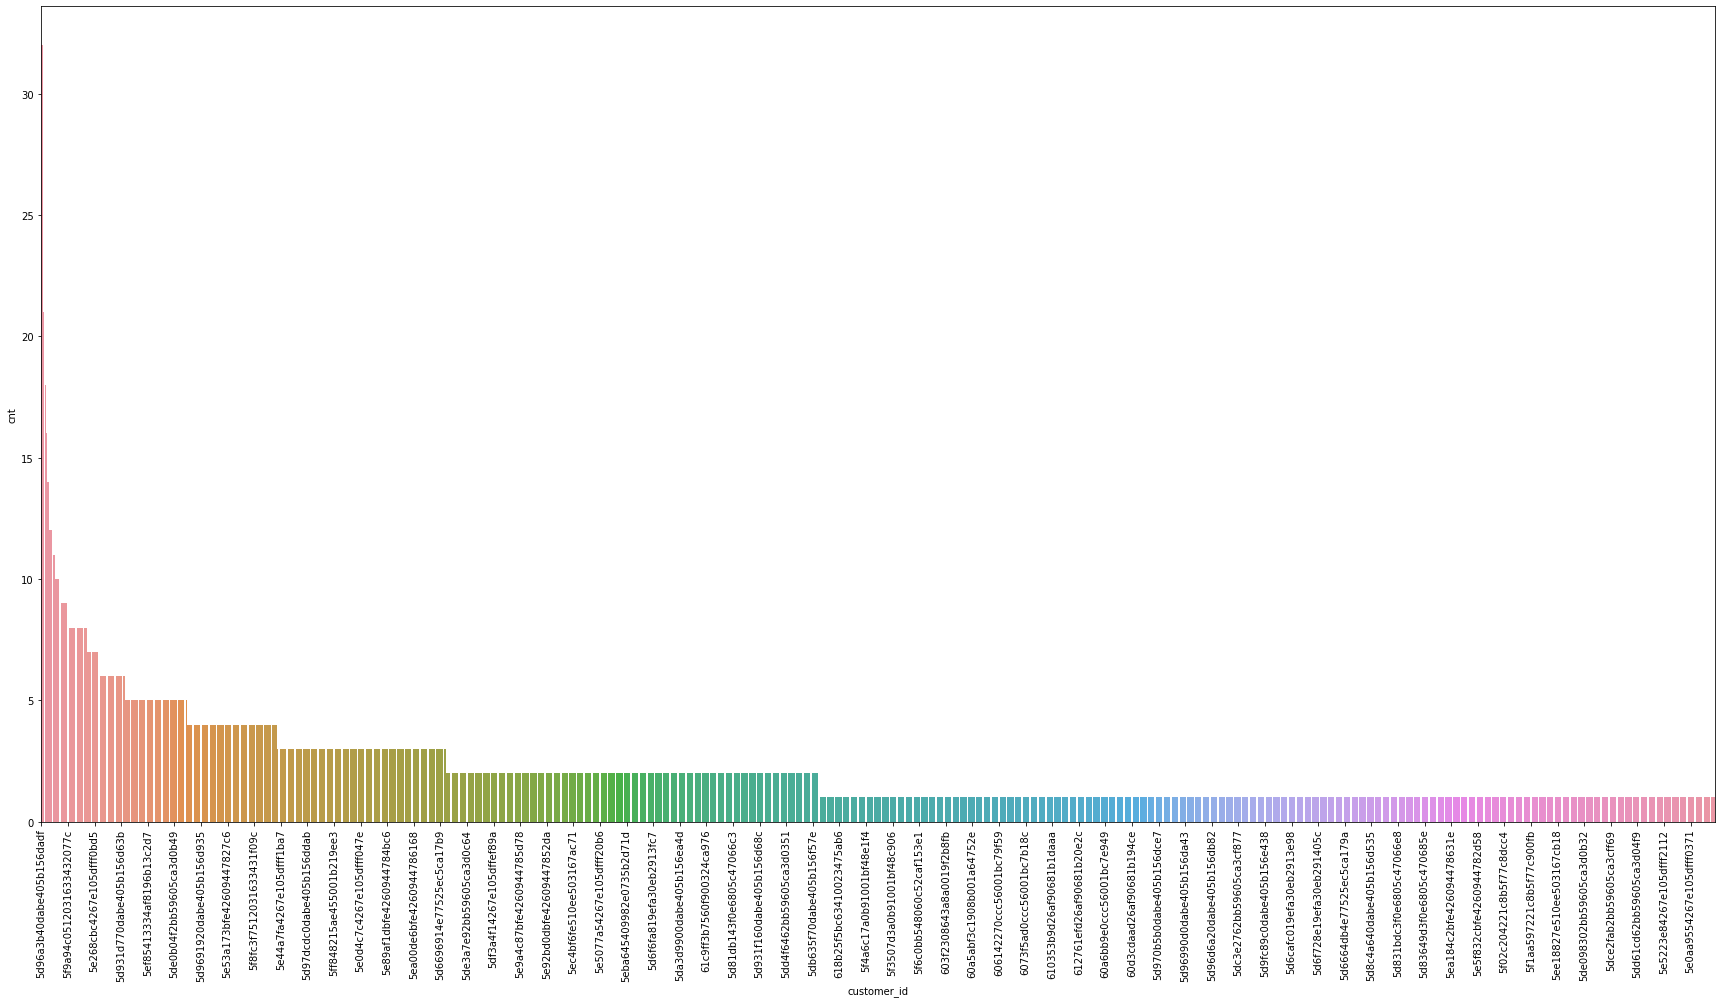

In [276]:
x = user_group_df['customer_id']
y = user_group_df['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
plt.xticks(rotation=90)
plt.show()

In [277]:
print('전체 유저 평균 구매 횟수:', user_group_df.mean())

전체 유저 평균 구매 횟수: cnt    2.130826
dtype: float64


In [278]:
print('가장 많이 구매한 유저 기록:',user_group_df.max())

가장 많이 구매한 유저 기록: customer_id    62e87979a3d1d80023058b36
cnt                                  32
dtype: object


In [279]:
product_df = all_promotion_df.groupby('product_ids')[['product_ids']].count().rename(columns={'product_ids':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)

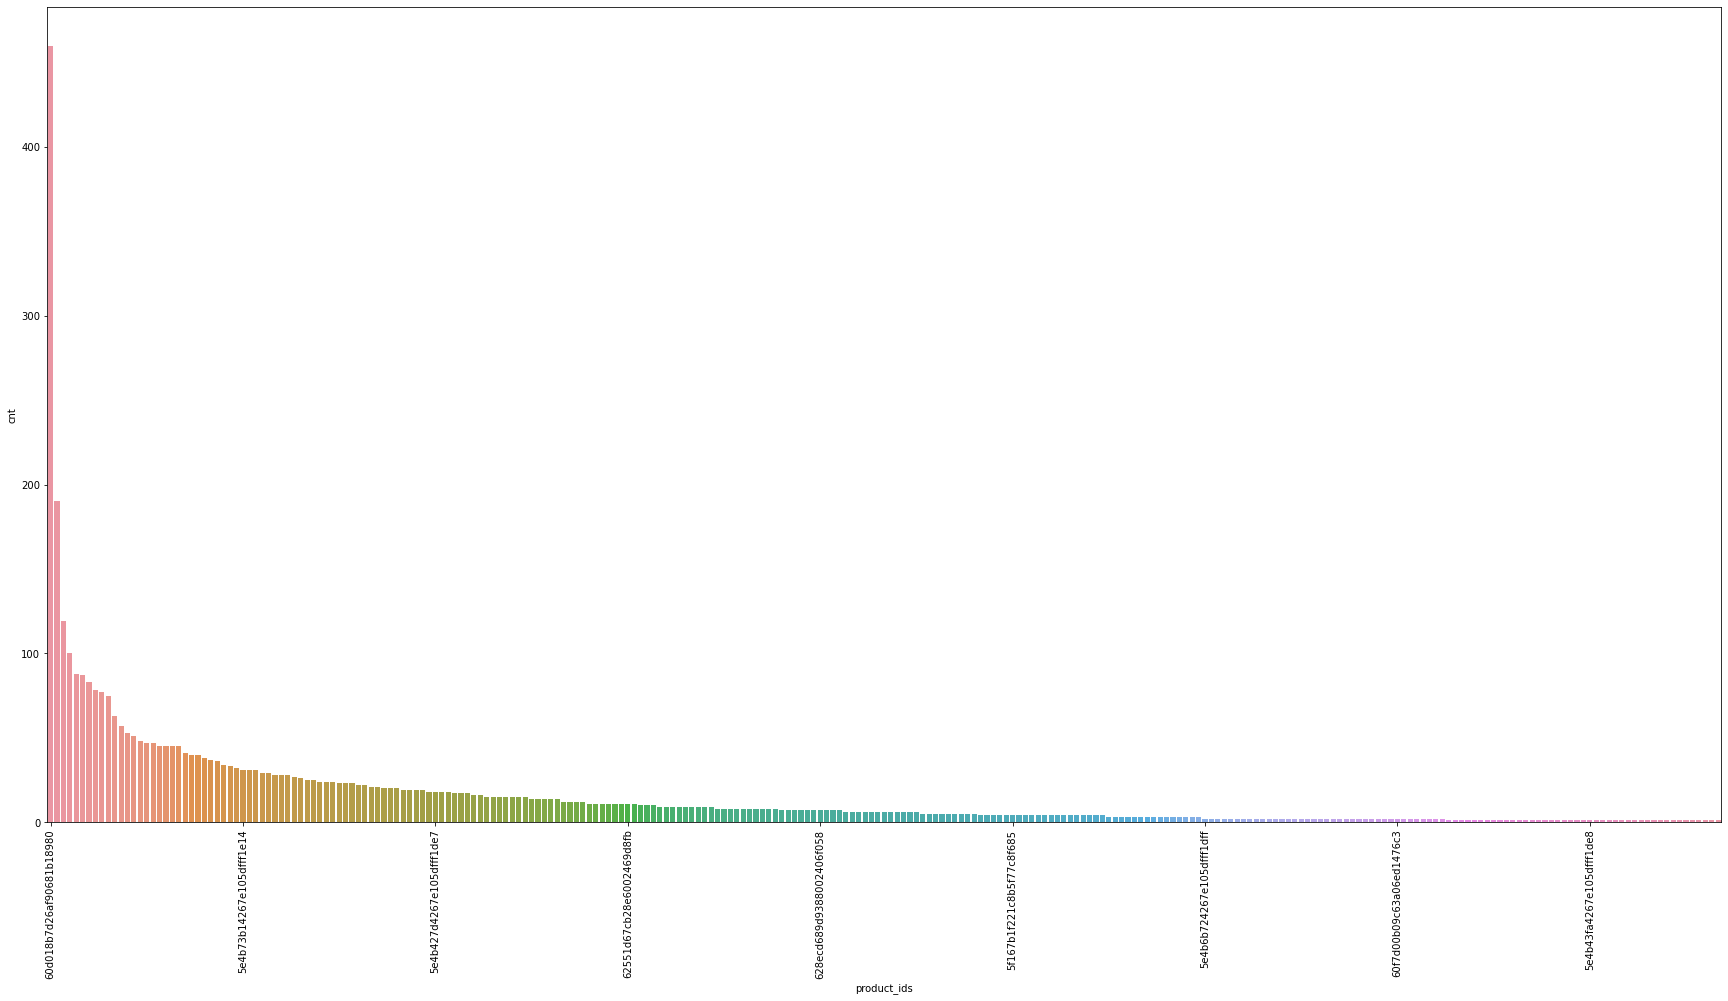

In [280]:
x = product_df['product_ids']
y = product_df['cnt']

plt.figure(figsize=(30,15))
ax = sns.barplot(x=x,y=y)
total_len = len(x)
ax.set_xticks(np.arange(0, total_len+1, 30))
plt.xticks(rotation=90)
plt.show()

- 상위 몇개의 책이 거의 독점적으로 팔림

In [281]:
all_promotion_df.groupby(['product_ids','name_x'])['_id'].count().reset_index().rename(columns={'_id':'cnt'}).sort_values(by='cnt',ascending=False).head()

,product_ids,name_x,cnt
171,60d018b7d26af90681b18980,윤상훈·권병조의 알짜 근육학,460
184,610b6f9ad26af90681b1e699,임상 한의사를 위한 기본 한약처방 강의 2판,190
199,617f9228bc63410023472aa4,숲을 보는 요통치료,119
0,5d13115e32026c0b35383897,KCD 한방내과 진찰진단 가이드라인,100
198,617a3aacbc63410023471ab6,트리거포인트 침치료,88


- 윤상훈·권병조의 알짜 근육학 책이 눈에 띄게 많이 팔림

In [282]:
print('전체 평균 판매 횟수:', product_df.mean())

전체 평균 판매 횟수: cnt    15.413793
dtype: float64


In [283]:
print('가장 많이 판매된 도서 기록:',product_df.max())

가장 많이 판매된 도서 기록: product_ids    62da5dd81b3c480022189fdf
cnt                                 460
dtype: object
